In [500]:
import pandas as pd
import torch
import matplotlib.pyplot as plt

In [501]:
trainDF = pd.read_csv('train.csv')
trainDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [502]:
testDF = pd.read_csv('test.csv')
testDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [503]:
concatDF = pd.concat([trainDF,testDF])

concatDF['Age'] = concatDF['Age'].fillna(concatDF['Age'].mean())
concatDF['Fare'] = concatDF['Fare'].fillna(concatDF['Fare'].mean())
concatDF['Cabin'] = concatDF['Cabin'].fillna(0)
concatDF['Embarked'] = concatDF['Embarked'].fillna(0)

concatDF= pd.get_dummies(concatDF,columns=['Pclass','Sex','Cabin','Embarked'])

concatDF = concatDF.drop(columns=['Name','Ticket'])
trainDF = concatDF.iloc[:890]
testDF = concatDF.iloc[891:]
testDF = testDF.drop(columns=['Survived'])

In [504]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, DF):


        self.PassengerId= DF['PassengerId'].values
        # self.Pclass= pd.get_dummies(DF['Pclass']).values
        # self.Sex= pd.get_dummies(DF['Sex']).values
        # self.Age= DF['Age'].values
        # self.SibSp= DF['SibSp'].values
        # self.Parch= DF['Parch'].values
        # self.Fare= DF['Fare'].values
        # self.Cabin= pd.get_dummies(DF['Cabin']).values
        # self.Embarked= pd.get_dummies(DF['Embarked']).values

        if 'Survived' in DF.columns: 
            self.Servived = pd.get_dummies(DF['Survived']).values
            self.DF = DF.drop(columns=['PassengerId','Survived']).astype(float).values
        else:
            self.DF = DF.drop(columns=['PassengerId',]).astype(float).values
        pass

    def __len__(self):
        return len(self.PassengerId)

    def __getitem__(self, idx):

        x = torch.FloatTensor(self.DF[idx])

        if hasattr(self,'Servived'):
            y = torch.FloatTensor(self.Servived[idx])
            return x, y
        else:
            y = self.PassengerId[idx]
            return x, y


trainSet = MyDataset(DF=trainDF)
testSet = MyDataset(DF=testDF)
# trainSet[0][0].shape
testSet[0][1]

892

In [505]:

testSet = MyDataset(DF=testDF)

In [506]:
trainLoader= torch.utils.data.DataLoader(trainSet,batch_size=2048)
testLoader = torch.utils.data.DataLoader(testSet)
next(iter(trainLoader))

[tensor([[22.0000,  1.0000,  0.0000,  ...,  0.0000,  0.0000,  1.0000],
         [38.0000,  1.0000,  0.0000,  ...,  1.0000,  0.0000,  0.0000],
         [26.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  1.0000],
         ...,
         [19.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  1.0000],
         [29.8811,  1.0000,  2.0000,  ...,  0.0000,  0.0000,  1.0000],
         [26.0000,  0.0000,  0.0000,  ...,  1.0000,  0.0000,  0.0000]]),
 tensor([[1., 0.],
         [0., 1.],
         [0., 1.],
         ...,
         [0., 1.],
         [1., 0.],
         [0., 1.]])]

In [507]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Define model
class NeuralNetwork(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = torch.nn.Sequential(
            torch.nn.Linear(200, 100),
            torch.nn.ReLU(),
            torch.nn.Linear(100, 50),
            torch.nn.ReLU(),
            torch.nn.Linear(50, 2)
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using mps device
NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=200, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=50, bias=True)
    (3): ReLU()
    (4): Linear(in_features=50, out_features=2, bias=True)
  )
)


In [508]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters())

In [509]:
def trainAI(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    totalLoss=0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        totalLoss +=loss.item()

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    print(totalLoss)
    return totalLoss

0.4139089286327362
0.4141576588153839
0.4142342209815979
0.41444218158721924
0.4144730865955353
0.41469863057136536
0.4146265685558319
0.41479921340942383
0.41470614075660706
0.4148043096065521
0.41461697220802307
0.4144609570503235
0.4142796993255615
0.4141122102737427
0.41403886675834656
0.4139293432235718
0.4139184355735779
0.41383180022239685
0.41384586691856384
0.4137538969516754
0.4137741029262543
0.4139178991317749
0.41395050287246704
0.4141201078891754
0.4141175150871277
0.4143528342247009
0.41438424587249756
0.4145679473876953
0.4144829213619232
0.4146028459072113
0.41445308923721313
0.41431817412376404
0.41424065828323364
0.41409337520599365
0.41409212350845337
0.41397807002067566
0.41398006677627563
0.41409578919410706
0.4141140580177307
0.41427096724510193
0.41424423456192017
0.41442781686782837
0.4143264591693878
0.41421863436698914
0.4141756594181061
0.4143257737159729
0.41431158781051636
0.4144838750362396
0.41439029574394226
0.4142395257949829
0.4141773581504822
0.41400

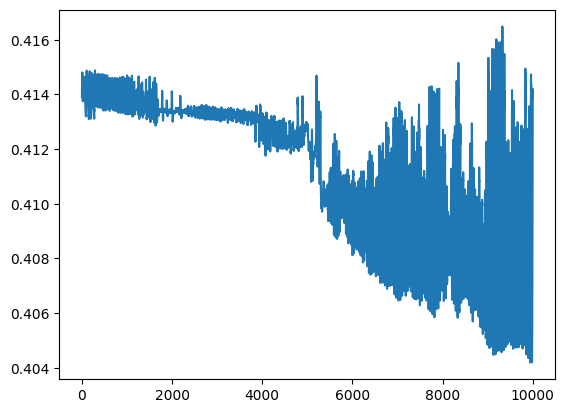

In [516]:
epochs = 10000
totalLoss=[]
for t in range(epochs):
    totalLoss.append(trainAI(trainLoader, model, loss_fn, optimizer))
print("Done!")

plt.plot(totalLoss)

In [517]:
def testAI(dataloader, model):
    model.eval()
    out = []
    with torch.no_grad():
        for X ,y  in dataloader:
            X  = X.to(device)
            pred = model(X)
            out.append([y.item(), torch.argmax(pred).item()])
    return out
result = testAI(testLoader, model)
result

[[892, 0],
 [893, 0],
 [894, 0],
 [895, 0],
 [896, 1],
 [897, 0],
 [898, 1],
 [899, 0],
 [900, 1],
 [901, 0],
 [902, 0],
 [903, 0],
 [904, 1],
 [905, 0],
 [906, 1],
 [907, 1],
 [908, 0],
 [909, 0],
 [910, 1],
 [911, 1],
 [912, 0],
 [913, 0],
 [914, 1],
 [915, 1],
 [916, 1],
 [917, 0],
 [918, 1],
 [919, 0],
 [920, 0],
 [921, 0],
 [922, 0],
 [923, 0],
 [924, 0],
 [925, 0],
 [926, 1],
 [927, 0],
 [928, 1],
 [929, 1],
 [930, 0],
 [931, 0],
 [932, 0],
 [933, 1],
 [934, 0],
 [935, 1],
 [936, 1],
 [937, 0],
 [938, 1],
 [939, 0],
 [940, 1],
 [941, 0],
 [942, 1],
 [943, 0],
 [944, 1],
 [945, 1],
 [946, 0],
 [947, 0],
 [948, 0],
 [949, 0],
 [950, 0],
 [951, 1],
 [952, 0],
 [953, 0],
 [954, 0],
 [955, 1],
 [956, 1],
 [957, 1],
 [958, 1],
 [959, 0],
 [960, 1],
 [961, 1],
 [962, 1],
 [963, 0],
 [964, 1],
 [965, 1],
 [966, 1],
 [967, 1],
 [968, 0],
 [969, 1],
 [970, 0],
 [971, 1],
 [972, 0],
 [973, 1],
 [974, 0],
 [975, 0],
 [976, 0],
 [977, 0],
 [978, 1],
 [979, 1],
 [980, 1],
 [981, 1],
 [982, 1],

In [518]:
result = pd.DataFrame(result)
result = result.astype(int)
result.columns=['passengerId','Survived']
result

,passengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [513]:
result.to_csv('result.csv',index=False)